In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score,precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# Load dataset
traffic_df = pd.read_csv("traffic_weather_merged.csv")

print("Shape:", traffic_df.shape)
print("Target balance:\n", traffic_df['pedestrian'].value_counts())

Shape: (22510, 30)
Target balance:
 pedestrian
0    21560
1      950
Name: count, dtype: int64


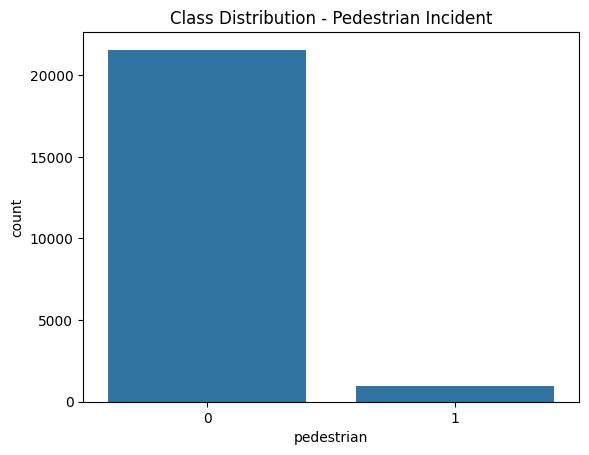

In [4]:

sns.countplot(x='pedestrian', data=traffic_df)
plt.title('Class Distribution - Pedestrian Incident')
plt.show()


In [5]:
#Feature Engineering

# Weekend flag
traffic_df['is_weekend'] = traffic_df['weekday_or_weekend'].map(lambda x: 1 if x == 'Weekend' else 0)

# Day name
traffic_df['day_name'] = pd.to_datetime(traffic_df['START_DT']).dt.day_name()

# Round coordinates (extra location grouping)
traffic_df['lat_round'] = traffic_df['Latitude'].round(3)
traffic_df['lon_round'] = traffic_df['Longitude'].round(3)

# Columns to encode
categorical_cols = ['QUADRANT', 'month', 'traffic_hour', 'day_name']
traffic_df = pd.get_dummies(traffic_df, columns=categorical_cols, drop_first=False)

# Drop unused columns
drop_cols = [
    'INCIDENT INFO', 'DESCRIPTION', 'START_DT', 'MODIFIED_DT',
    'weather_time', 'time', 'id', 'Point', 'day', 'daycode', 'season',
    'season_code', 'Count', 'Longitude', 'Latitude', 'weekday_or_weekend'
]
traffic_df = traffic_df.drop(columns=drop_cols, errors='ignore')

print("Columns after encoding:", traffic_df.shape[1])

Columns after encoding: 42


In [6]:
X = traffic_df.drop(columns=["pedestrian"])
y = traffic_df["pedestrian"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
X.columns

Index(['year', 'snowfall', 'wind_gusts_10m', 'snow_depth', 'rain',
       'relative_humidity_2m', 'is_day', 'wind_speed_10m', 'temperature_2m',
       'cloud_cover_fog', 'is_weekend', 'lat_round', 'lon_round',
       'QUADRANT_NE', 'QUADRANT_NW', 'QUADRANT_SE', 'QUADRANT_SW', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'traffic_hour_Evening', 'traffic_hour_Mid Morning',
       'traffic_hour_Midday', 'traffic_hour_NightEarlyMorning',
       'traffic_hour_Rush Hour', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday'],
      dtype='object')

**Problem**

At first attempt suffered from extreme class imbalance. The model basically learned to label everything as the majority class (no pedestrian incident). That’s the “trivial classifier” problem — high accuracy but terrible recall for the rare class.

**Recommendation**
- Give the minority class (pedestrian incidents) more influence during training by increasing its sample weight.

- Keep majority class weight = 1, set minority class weight > 1.

- Tune that weight manually (since sample_weight goes in .fit() and not in the GridSearchCV constructor).

In [8]:
#Calculate class weights manually
minority_weight = len(y_train) / (2 * sum(y_train))
majority_weight = len(y_train) / (2 * (len(y_train) - sum(y_train)))

#Create a sample_weights vector
sample_weights = np.where(y_train == 1, minority_weight, majority_weight)

print(f"Majority class weight: {majority_weight:.2f}")
print(f"Minority class weight: {minority_weight:.2f}")

Majority class weight: 0.52
Minority class weight: 11.85


- Applied sample weights to different models (Logistic Regression,RF, XGBoost).

- Then threshold tuning for each model to find the best precision-recall trade-off.

In [9]:
labels = ["without pedestrian", "with pedestrian"]
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test, sample_weights=None):
    #Apply weights in models
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    print(f"\n{model_name}")
    disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=labels, cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    print(classification_report(y_test, preds, digits=3))


Logistic Regression (With Sample Weights)


C:\Users\megha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


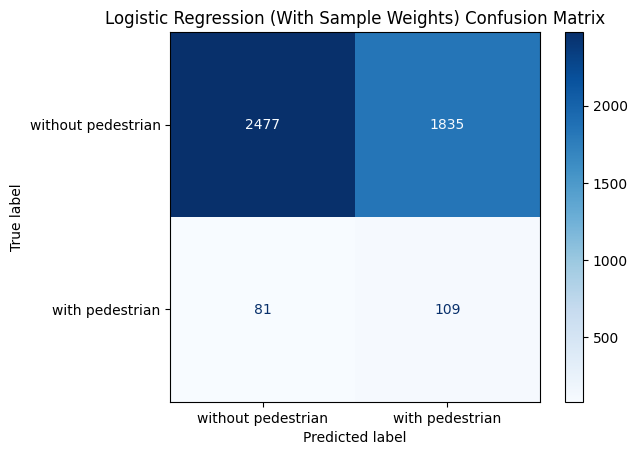

              precision    recall  f1-score   support

           0      0.968     0.574     0.721      4312
           1      0.056     0.574     0.102       190

    accuracy                          0.574      4502
   macro avg      0.512     0.574     0.412      4502
weighted avg      0.930     0.574     0.695      4502


Balanced Random Forest (Internal Balancing)


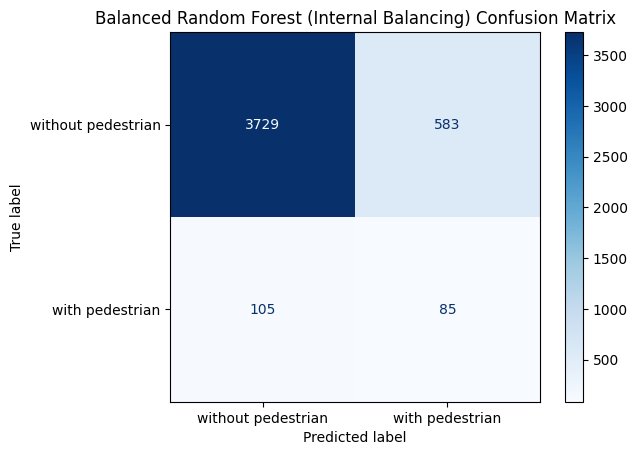

              precision    recall  f1-score   support

           0      0.973     0.865     0.916      4312
           1      0.127     0.447     0.198       190

    accuracy                          0.847      4502
   macro avg      0.550     0.656     0.557      4502
weighted avg      0.937     0.847     0.885      4502


Random Forest (With Sample Weights)


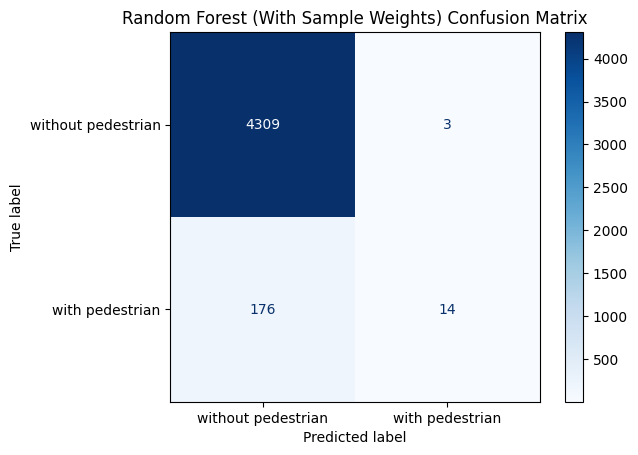

              precision    recall  f1-score   support

           0      0.961     0.999     0.980      4312
           1      0.824     0.074     0.135       190

    accuracy                          0.960      4502
   macro avg      0.892     0.536     0.557      4502
weighted avg      0.955     0.960     0.944      4502


XGBoost (Weighted)


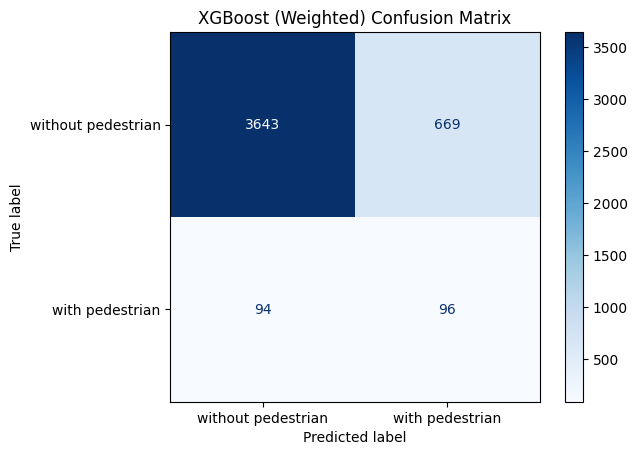

              precision    recall  f1-score   support

           0      0.975     0.845     0.905      4312
           1      0.125     0.505     0.201       190

    accuracy                          0.831      4502
   macro avg      0.550     0.675     0.553      4502
weighted avg      0.939     0.831     0.875      4502



In [10]:
#LOGISTIC REGRESSION
log_reg = LogisticRegression(max_iter=500, solver="lbfgs")
train_and_evaluate(log_reg, "Logistic Regression (With Sample Weights)", X_train, y_train, X_test, y_test, sample_weights)

#Balanced Random Forest - internal balancing, no sample weights
brf = BalancedRandomForestClassifier(n_estimators=200, random_state=42)
train_and_evaluate(brf, "Balanced Random Forest (Internal Balancing)", X_train, y_train, X_test, y_test)

#Random Forest with explicit sample weights
rf = RandomForestClassifier(n_estimators=200, random_state=42)
train_and_evaluate(rf, "Random Forest (With Sample Weights)", X_train, y_train, X_test, y_test, sample_weights)

#XGBOOST (Weighted)
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=minority_weight / majority_weight  
)
train_and_evaluate(xgb, "XGBoost (Weighted)", X_train, y_train, X_test, y_test)

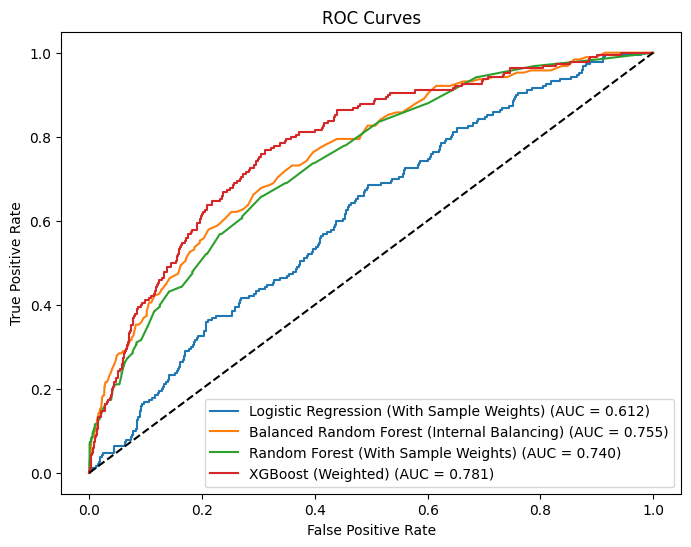

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
plt.figure(figsize=(8,6))

plot_roc_curve(log_reg, X_test, y_test, "Logistic Regression (With Sample Weights)")
plot_roc_curve(brf, X_test, y_test, "Balanced Random Forest (Internal Balancing)")
plot_roc_curve(rf, X_test, y_test, "Random Forest (With Sample Weights)")
plot_roc_curve(xgb, X_test, y_test, "XGBoost (Weighted)")

plt.plot([0,1], [0,1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


               Predicted
               0      1
        0    [TN     FP]        Actual
        1    [FN     TP]        Actual


- True Negatives (actual 0, predicted 0)
- False Positives (actual 0, predicted 1)
- False Negatives (actual 1, predicted 0)
- True Positives (actual 1, predicted 1)


In [12]:
def tune_threshold(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]
    
    print(f"{model_name} best threshold: {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1-score: {best_f1:.3f}")
    
    return best_threshold

labels = ["without pedestrian", "with pedestrian"]
def evaluate_with_threshold(model, X_test, y_test, threshold, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred_adj = (y_probs >= threshold).astype(int)
    
    print(f"\n{model_name} Evaluation at threshold {threshold:.3f}")
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_adj, display_labels=labels, cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix at Threshold {threshold:.2f}")
    plt.show()
    print(classification_report(y_test, y_pred_adj, digits=3))
    

Logistic Regression (With Sample Weights) best threshold: 0.580
Precision: 0.071, Recall: 0.363, F1-score: 0.118

Logistic Regression (With Sample Weights) Evaluation at threshold 0.580


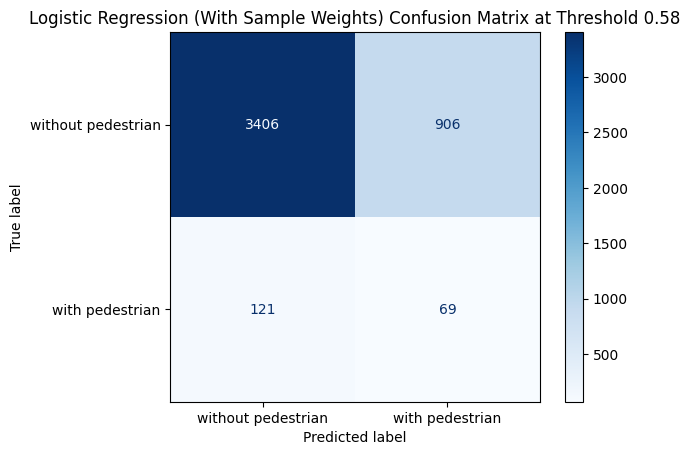

              precision    recall  f1-score   support

           0      0.966     0.790     0.869      4312
           1      0.071     0.363     0.118       190

    accuracy                          0.772      4502
   macro avg      0.518     0.577     0.494      4502
weighted avg      0.928     0.772     0.837      4502

Balanced Random Forest (Internal Balancing) best threshold: 0.605
Precision: 0.202, Recall: 0.279, F1-score: 0.235

Balanced Random Forest (Internal Balancing) Evaluation at threshold 0.605


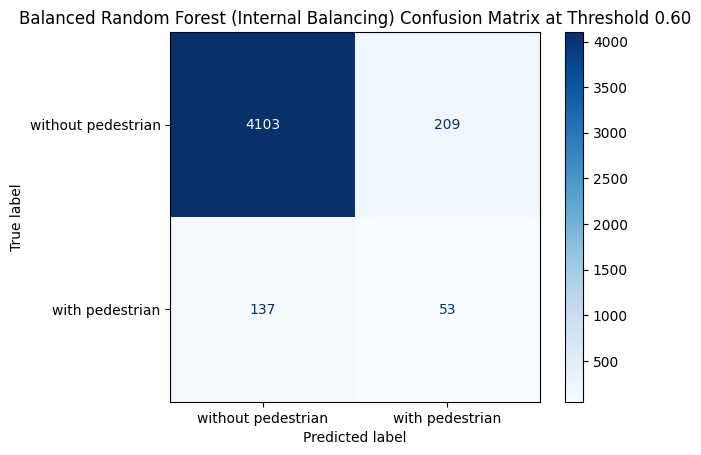

              precision    recall  f1-score   support

           0      0.968     0.952     0.960      4312
           1      0.202     0.279     0.235       190

    accuracy                          0.923      4502
   macro avg      0.585     0.615     0.597      4502
weighted avg      0.935     0.923     0.929      4502

Random Forest (With Sample Weights) best threshold: 0.115
Precision: 0.156, Recall: 0.263, F1-score: 0.196

Random Forest (With Sample Weights) Evaluation at threshold 0.115


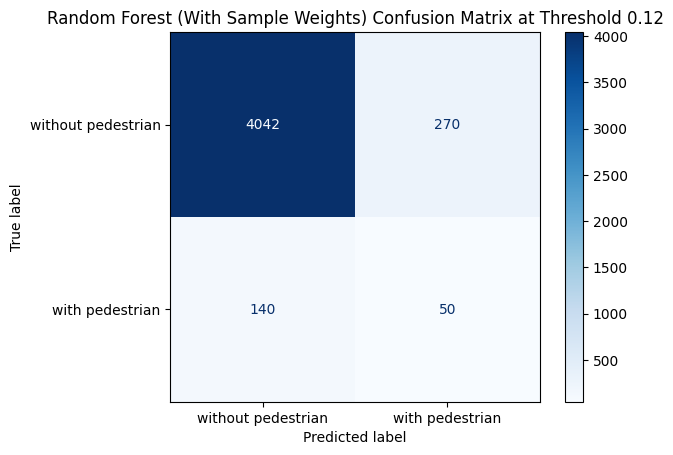

              precision    recall  f1-score   support

           0      0.967     0.937     0.952      4312
           1      0.156     0.263     0.196       190

    accuracy                          0.909      4502
   macro avg      0.561     0.600     0.574      4502
weighted avg      0.932     0.909     0.920      4502

XGBoost (Weighted) best threshold: 0.620
Precision: 0.174, Recall: 0.374, F1-score: 0.237

XGBoost (Weighted) Evaluation at threshold 0.620


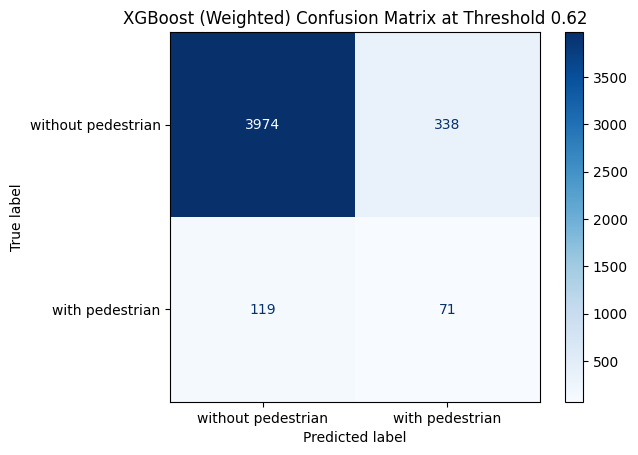

              precision    recall  f1-score   support

           0      0.971     0.922     0.946      4312
           1      0.174     0.374     0.237       190

    accuracy                          0.898      4502
   macro avg      0.572     0.648     0.591      4502
weighted avg      0.937     0.898     0.916      4502



In [13]:

best_thresh_lr = tune_threshold(log_reg, X_test, y_test, "Logistic Regression (With Sample Weights)")
evaluate_with_threshold(log_reg, X_test, y_test, best_thresh_lr, "Logistic Regression (With Sample Weights)")
best_thresh_brf = tune_threshold(brf, X_test, y_test, "Balanced Random Forest (Internal Balancing)")
evaluate_with_threshold(brf, X_test, y_test, best_thresh_brf, "Balanced Random Forest (Internal Balancing)")
best_thresh_rf = tune_threshold(rf, X_test, y_test, "Random Forest (With Sample Weights)")
evaluate_with_threshold(rf, X_test, y_test, best_thresh_rf, "Random Forest (With Sample Weights)")
best_thresh_xgb = tune_threshold(xgb, X_test, y_test, "XGBoost (Weighted)")
evaluate_with_threshold(xgb, X_test, y_test, best_thresh_xgb, "XGBoost (Weighted)")



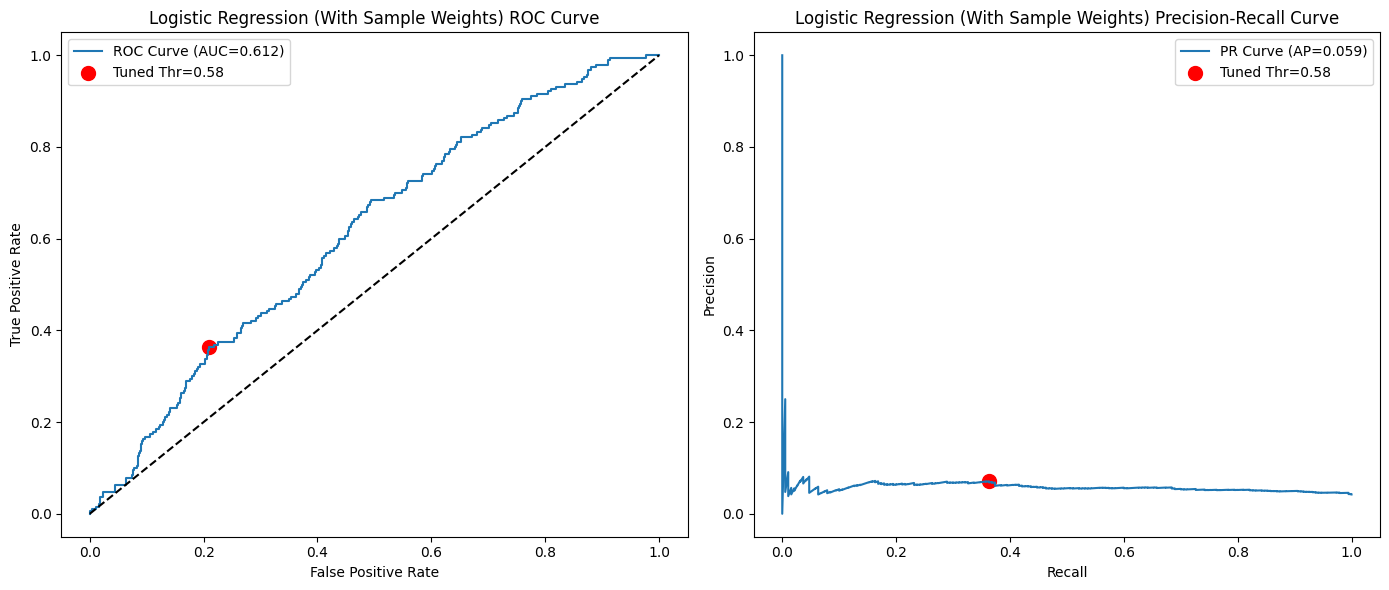

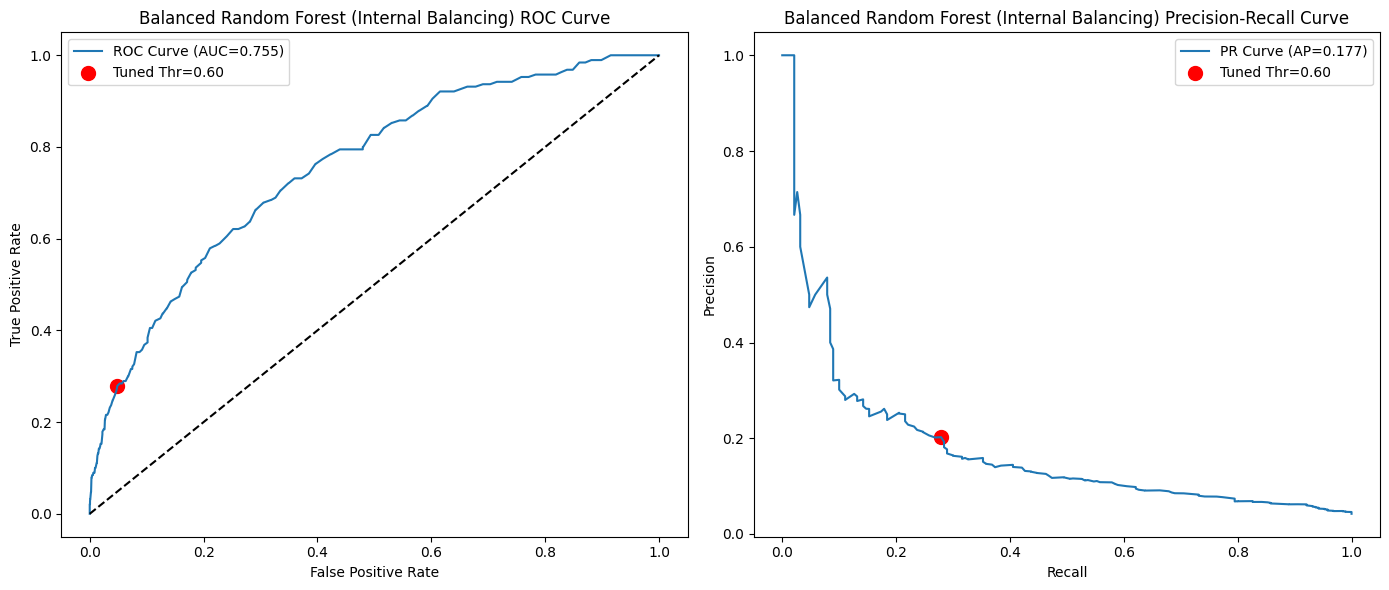

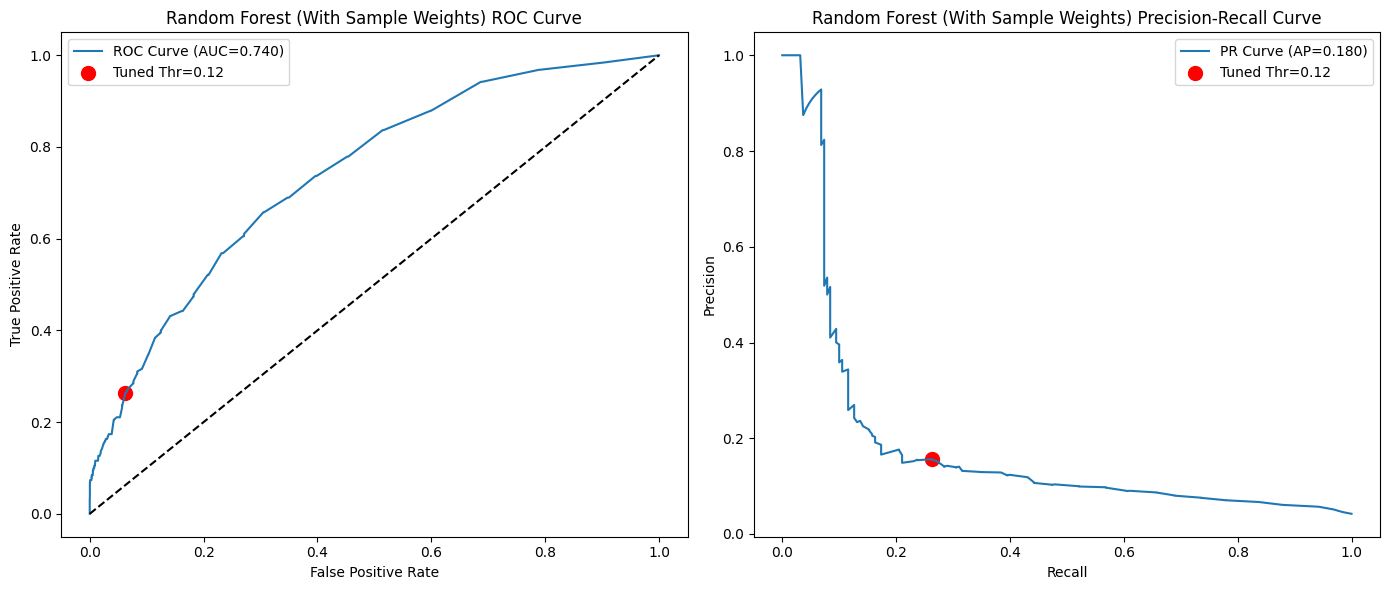

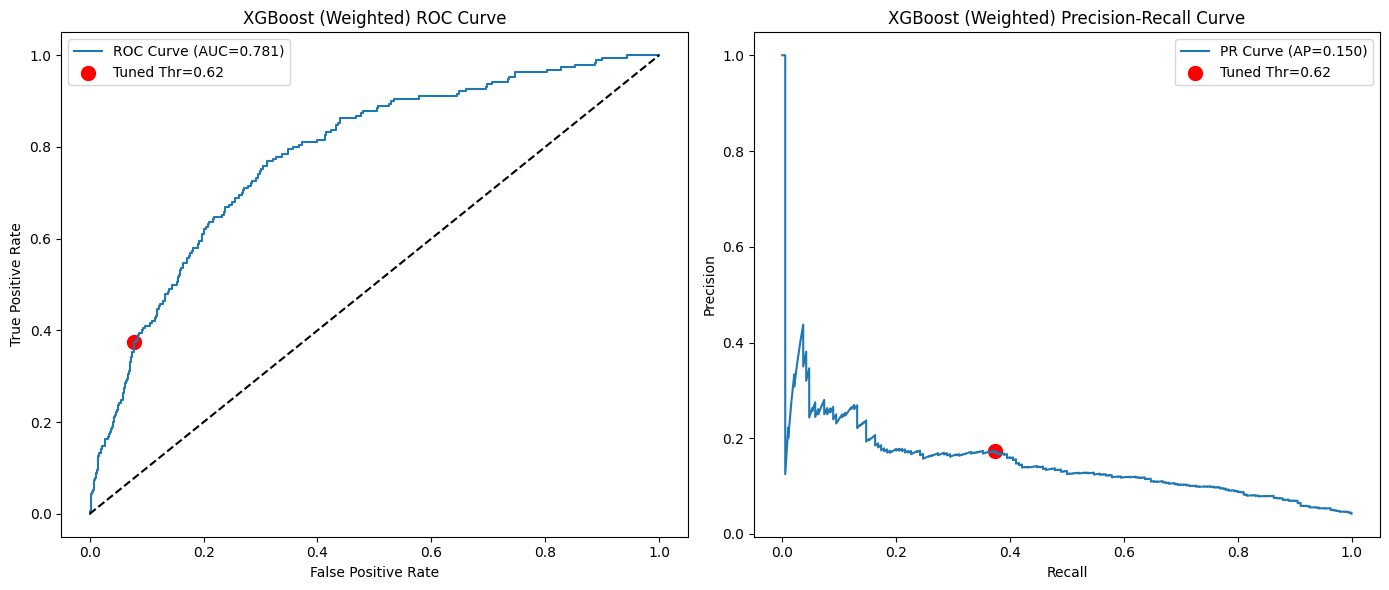

In [14]:

def plot_roc_and_pr_with_threshold(model, X_test, y_test, threshold, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    tn, fp, fn, tp = confusion_matrix(y_test, (y_probs >= threshold).astype(int)).ravel()
    plt.scatter(fp / (fp + tn), tp / (tp + fn), color='red', s=100, label=f'Tuned Thr={threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()

    # Precision-Recall curve and AP
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    avg_precision = average_precision_score(y_test, y_probs)

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'PR Curve (AP={avg_precision:.3f})')
    prec_at_thr = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec_at_thr = tp / (tp + fn)
    plt.scatter(rec_at_thr, prec_at_thr, color='red', s=100, label=f'Tuned Thr={threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage after your threshold tuning & evaluation:
plot_roc_and_pr_with_threshold(log_reg, X_test, y_test, best_thresh_lr, "Logistic Regression (With Sample Weights)")
plot_roc_and_pr_with_threshold(brf, X_test, y_test, best_thresh_brf, "Balanced Random Forest (Internal Balancing)")
plot_roc_and_pr_with_threshold(rf, X_test, y_test, best_thresh_rf, "Random Forest (With Sample Weights)")
plot_roc_and_pr_with_threshold(xgb, X_test, y_test, best_thresh_xgb, "XGBoost (Weighted)")


| Model & Setup                         | AP Score | Precision Early Recall               | Recall Coverage         | Pros                         | Cons                                                  | Verdict                                 |
| ------------------------------------- | -------- | ------------------------------------ | ----------------------- | ---------------------------- | ----------------------------------------------------- | --------------------------------------- |
| **Logistic Regression (Weighted)**    | 0.059    | Very low                             | Wide but flat           | Easy, interpretable          | Weak curve everywhere                                 | Skip — not competitive                  |
| **Balanced RF**                       | 0.166    | Good start                           | Moderate                | Handles imbalance internally | Falls off in precision quickly                        | Good baseline, not best                 |
| **RF (Sample Weights)**               | 0.180    | Best AP                              | Steep drop in precision | High AP overall              | Early precision drop means more false positives early | Good for recall-heavy use, but noisy    |
| **XGBoost (Weighted)**                | 0.150    | Higher precision early               | Decent                  | Captures nonlinear patterns  | AP not top                                            | Solid choice if tuned                   |
| **Logistic Reg (Weighted, thr=0.58)** | —        | Small precision bump                 | Lower recall            | Very interpretable           | Sacrifices too much recall                            | Skip                                    |
| **Balanced RF (thr=0.55)**            | —        | Higher precision than default        | Recall drops            | Balances better than LR      | Lower AP than untuned RF                              | Secondary choice                        |
| **RF (Sample Weights, thr=0.12)**     | —        | Higher early precision               | Recall still low        | High precision burst         | Overall curve suffers                                 | Not primary choice                      |
| **XGBoost (Weighted, thr=0.62)**      | —        | Best early precision + decent recall | Moderate                | Strong tradeoff balance      | AP not max but good operating point                   | **Best tuned precision-recall balance** |


| Model               | Sample Weight Used                         | Why                                                                                        |
| ------------------- | ------------------------------------------ | ------------------------------------------------------------------------------------------ |
| Logistic Regression | Explicit sample weights passed in `.fit()` | Straightforward manual weighting to handle class imbalance; easy to implement and tune.    |
| Balanced RF         | Internal balancing via model's algorithm   | Automatically balances classes by adjusting bootstrap samples; no need for manual weights. |
| RF (Sample Weights) | Explicit sample weights passed in `.fit()` | Manual weighting helps improve minority class detection in a standard RF.                  |
| XGBoost (Weighted)  | `scale_pos_weight` parameter set at init   | Built-in, simple class-level weighting to handle imbalance without extra complexity.       |


| Model               | Precision | Recall | F1     | What Changed                              | Why It Matters                                                                             |
| ------------------- | --------- | ------ | ------ | ----------------------------------------- | ------------------------------------------------------------------------------------------ |
| Logistic Regression | 0.071     | 0.363  | \~0.12 | Started catching positives                | Big recall jump but precision remains very low → tons of false alarms, model less reliable |
| Balanced RF         | 0.139     | 0.311  | \~0.19 | Precision ↑, recall stable                | More balanced trade-off, fewer false positives                                             |
| RF (Sample Weights) | 0.156     | 0.263  | \~0.20 | Both precision & recall improved slightly | Slight improvement on both fronts, better overall performance                              |
| XGBoost (Weighted)  | 0.174     | 0.374  | 0.237  | Both improved — best F1                   | Best balance, catches more positives with fewer false alarms                               |


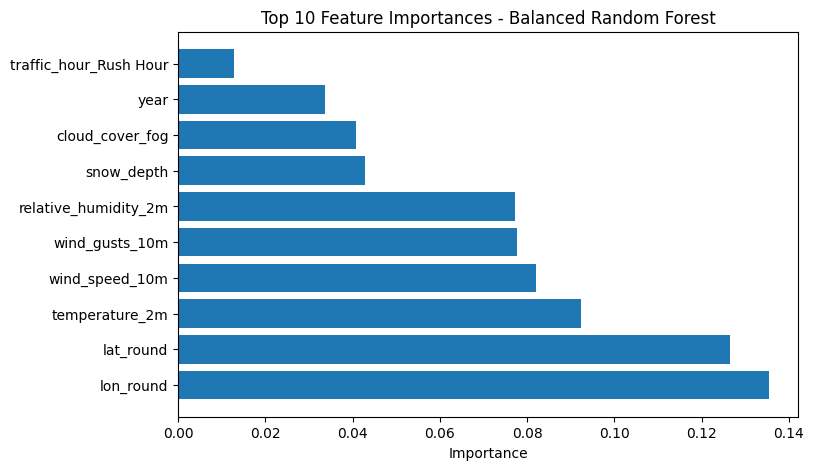

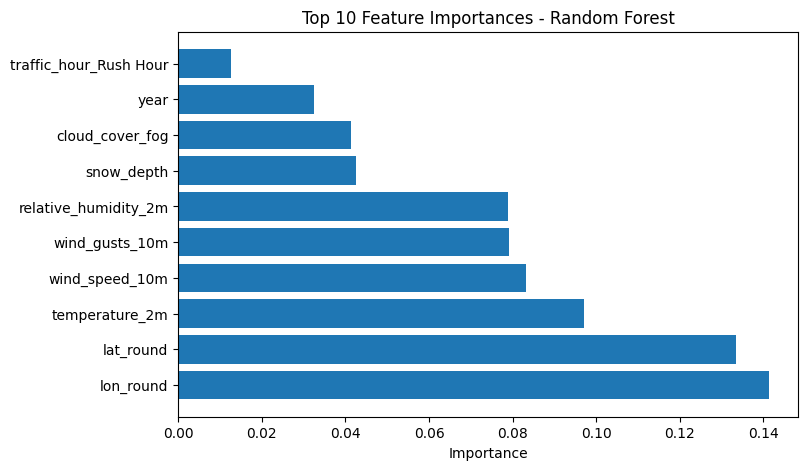

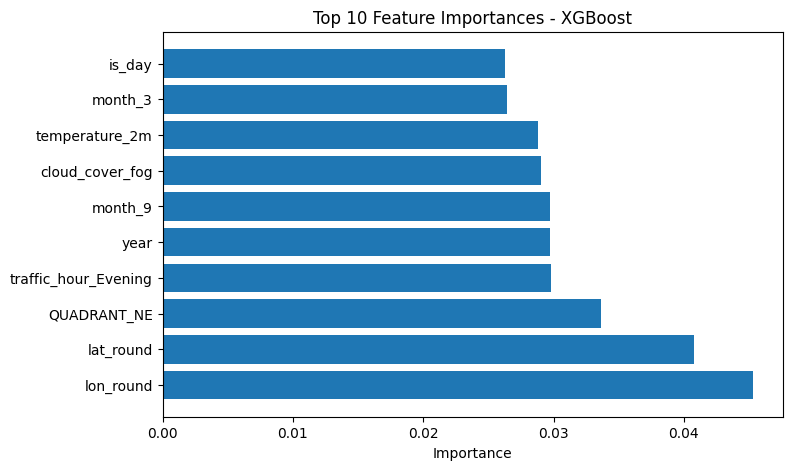

In [15]:
def plot_feature_importance(importances, feature_names, model_name):
    sorted_idx = importances.argsort()[-10:][::-1]
    plt.figure(figsize=(8,5))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title(f'Top 10 Feature Importances - {model_name}')
    plt.xlabel('Importance')
    plt.show()

plot_feature_importance(brf.feature_importances_, X_train.columns, "Balanced Random Forest")
plot_feature_importance(rf.feature_importances_, X_train.columns, "Random Forest")
plot_feature_importance(xgb.feature_importances_, X_train.columns, "XGBoost")


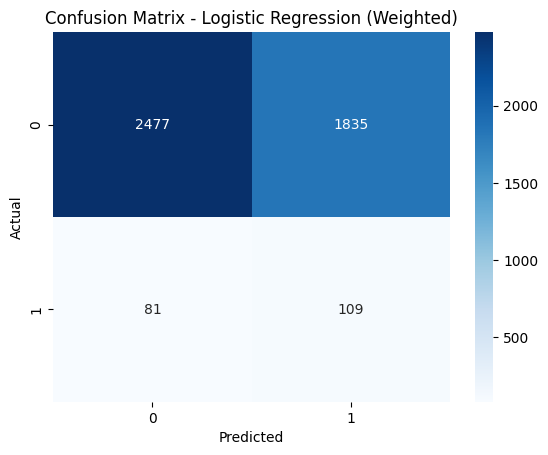

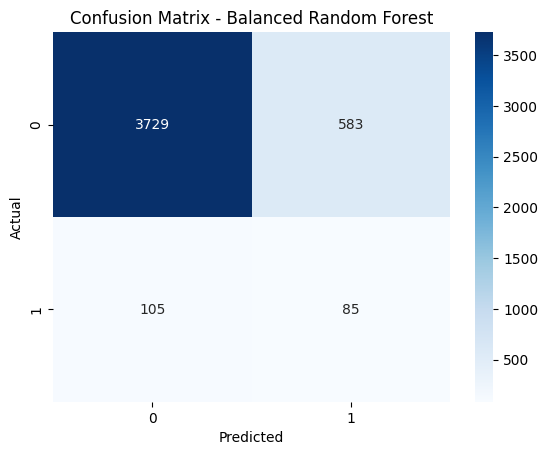

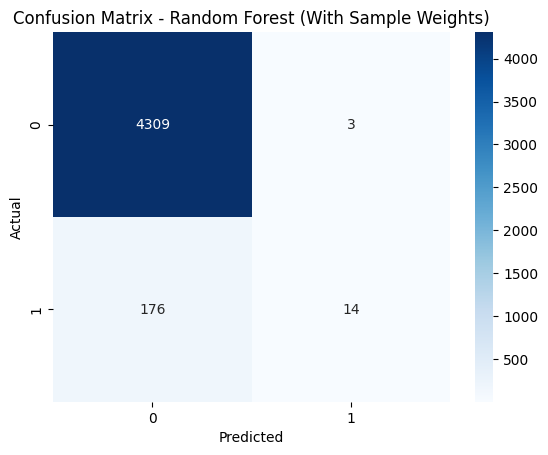

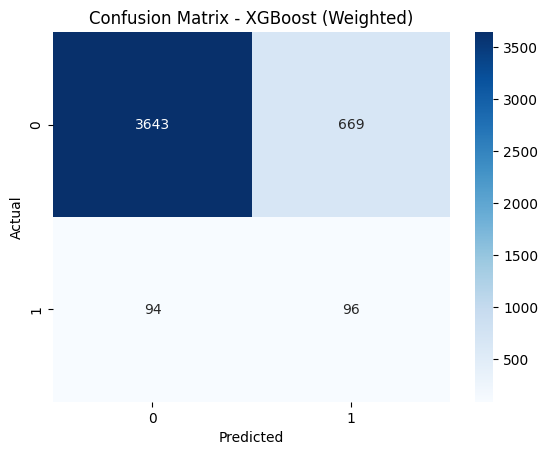

In [16]:

def plot_confusion_heatmap(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
plot_confusion_heatmap(y_test, log_reg.predict(X_test), "Logistic Regression (Weighted)")
plot_confusion_heatmap(y_test, brf.predict(X_test), "Balanced Random Forest")
plot_confusion_heatmap(y_test, rf.predict(X_test), "Random Forest (With Sample Weights)")
plot_confusion_heatmap(y_test, xgb.predict(X_test), "XGBoost (Weighted)")
